# Imports

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline

# File Parsing

In [3]:
def file_parser(ticker, data_directory='Sample_Data'):
    """Returns a dataframe containing collection time, seq num, price and size for given ticker.
    
    Parameter:
        ticker (str):            A string representing a stock ticker symbol 
        data_directory (str):    A string representing the directory which contains the data files.
    
    Returns:
        results_df (df):         A pandas dataframe containing: 
                                    collection time (<M8[ns]), 
                                    seq num (int: unique ID), 
                                    price (float), and 
                                    size (int) for a given ticker. 
    
    Raises: 
        ValueError:              If a subdirectory for 'ticker' is not found in the data_directory 
                                 OR if the subdirectory contains to .csv files. 

    """
    
    # From TextTickReader.pdf 
    column_headers = ['collection_time', 
                      'source_time', 
                      'seq_num',
                      'tick_type',
                      'market_center', 
                      'price', 
                      'size']
    
    df_list = []
    
    
    subdirectory = os.path.join(data_directory, ticker.upper())
    
    
    if not os.path.exists(subdirectory):
        print(subdirectory)
        raise ValueError(f'Subdirectory called {ticker} does not exist.')
    
    
    
    for filename in os.listdir(subdirectory):
        file_path = os.path.join(subdirectory, filename)
        
        tmp_df = pd.read_csv(file_path, names=column_headers)
        df_list.append(tmp_df)
    
    
    
    if df_list:
        result_df = pd.concat(df_list, ignore_index=True)
        
        # Dropping unnecessary columns
        # Retaining seq_num in case we ever want to combine multiple symbols into one df
        result_df = result_df[['collection_time',  
                               'seq_num',
                               'price', 
                               'size']]
    
        result_df['collection_time'] = pd.to_datetime(result_df['collection_time'], format='%Y-%m-%d %H:%M:%S.%f')
        result_df['seq_num'] = result_df['seq_num'].astype(int)
        result_df['price'] = result_df['price'].astype(float)
        result_df['size'] = result_df['size'].astype(int)
        
        result_df.set_index('collection_time', inplace=True)
        result_df.sort_index(inplace=True)
    
    else:
        raise ValueError(f'No CSV files found in {subdirectory}.')
        
    
    return result_df.dropna()

In [4]:
aapl = file_parser('aapl')

In [5]:
aapl.head()

seq_num   price  size
collection_time                                     
2019-10-01 12:04:15.787417088    29074  225.34   100
2019-10-01 12:04:17.534033920    29082  225.34   100
2019-10-01 12:18:28.372678912    35033  225.22   100
2019-10-01 13:19:28.659406080    66110  225.09   100
2019-10-01 13:19:34.267168000    66312  225.09   100

In [6]:
aapl.shape

(88372, 3)

In [42]:
qqq = file_parser('qqq')

In [43]:
qqq.head()

seq_num   price  size
collection_time                                     
2019-10-01 13:01:03.775358976    54492  189.47   100
2019-10-01 13:10:53.189507072    58416  189.59    40
2019-10-01 13:30:00.444678912    93431  189.47   100
2019-10-01 13:30:00.445464064    93438  189.47   100
2019-10-01 13:30:00.748318720    89880  189.52   100

# Plots

In [14]:
def plot_avg_daily_price(df):
    """
    Plot avg price of ticks day for day represented in the DataFrame.    
    """
    
    daily_prices = df.groupby(df.index.date)['price'].mean()
    
    plt.plot(daily_prices.index, daily_prices.values, label='Daily Price')
    
    plt.xlabel('Date', weight='bold')
    plt.ylabel('Price', weight='bold')
    plt.title('Average Price Per Day', weight='bold')
    plt.xticks(rotation=40)
    plt.show()

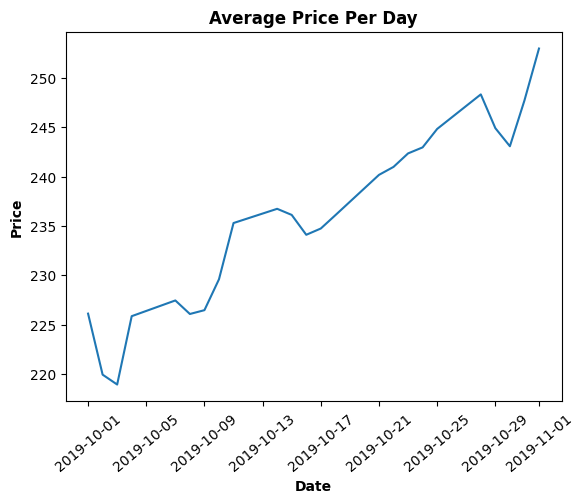

In [15]:
plot_avg_daily_price(aapl)

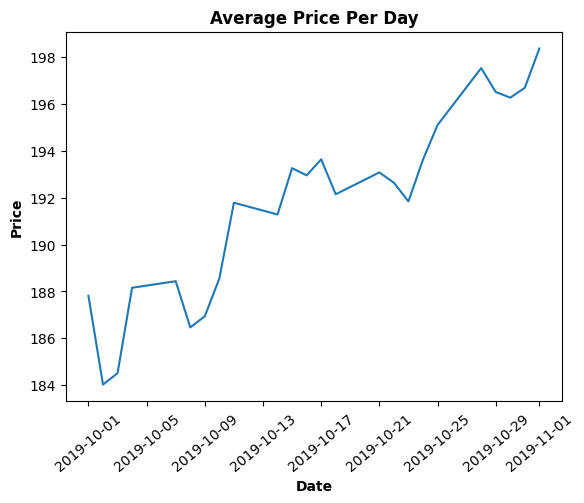

In [16]:
plot_avg_daily_price(qqq)

In [24]:
def plot_ticks_per_day(df):
    """
    Plots a line graph for every tick for each day represented in the DataFrame.
    
    """
    
    # Group by day
    grouped_data = df.groupby(df.index.date)
    
    for day, day_data in grouped_data:
        start_time = day_data.index.min()
        day_data['time_seconds'] = (day_data.index - start_time).total_seconds()
        
        plt.plot(day_data['time_seconds'], day_data['price'], label=f'Ticks on {day}')
    
    plt.xlabel('Time (seconds from market open)', weight='bold')
    plt.ylabel('Price', weight='bold')
    plt.title('Ticks Per Day Line Plot', weight='bold')
    plt.show()


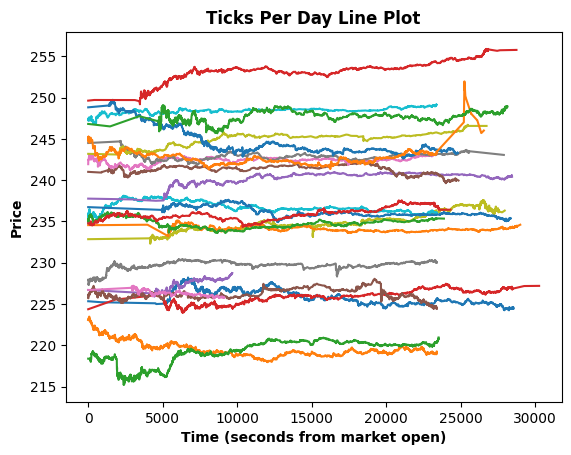

In [25]:
plot_ticks_per_day(aapl)

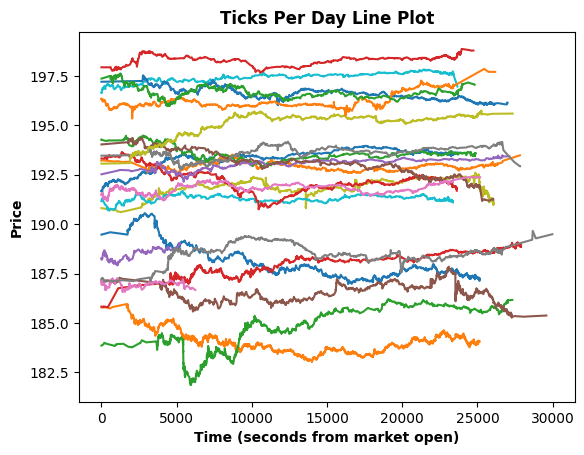

In [26]:
plot_ticks_per_day(qqq)

In [70]:
def plot_intraday_volatility(df):
    """
    Plot intraday volatility using rolling standard deviation.
    """

    grouped_data = df.groupby(df.index.date)
    
    plt.figure(figsize=(10, 6))
    
    for day, day_data in grouped_data:
        
        intraday_time_seconds = (day_data.index - day_data.index[0]).total_seconds()
        intraday_volatility = day_data['price'].pct_change().rolling(window=len(day_data), min_periods=1).std()
        plt.plot(intraday_time_seconds, intraday_volatility, label=f'Intraday Volatility - {day}')
    
    plt.xlabel('Intraday Time (seconds)')
    plt.ylabel('Volatility')
    plt.title('Intraday Volatility')
    plt.show()

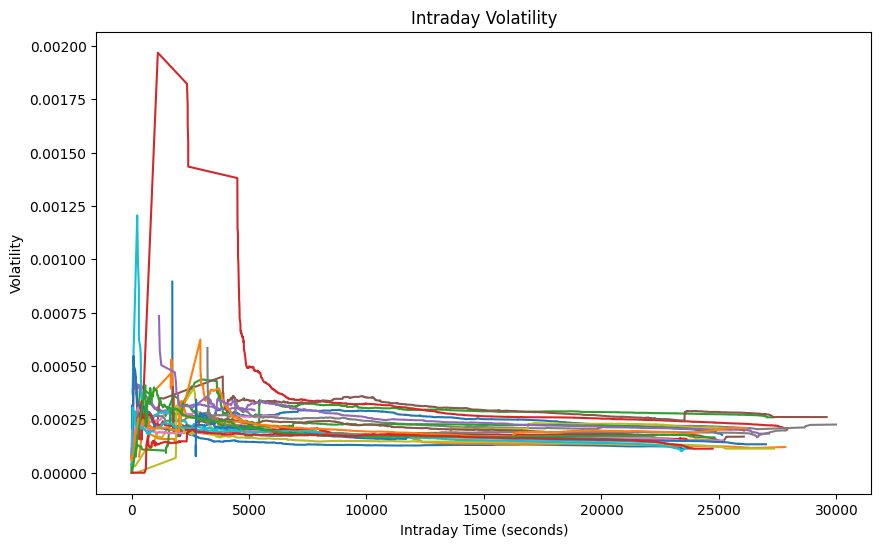

In [71]:
plot_intraday_volatility(qqq)

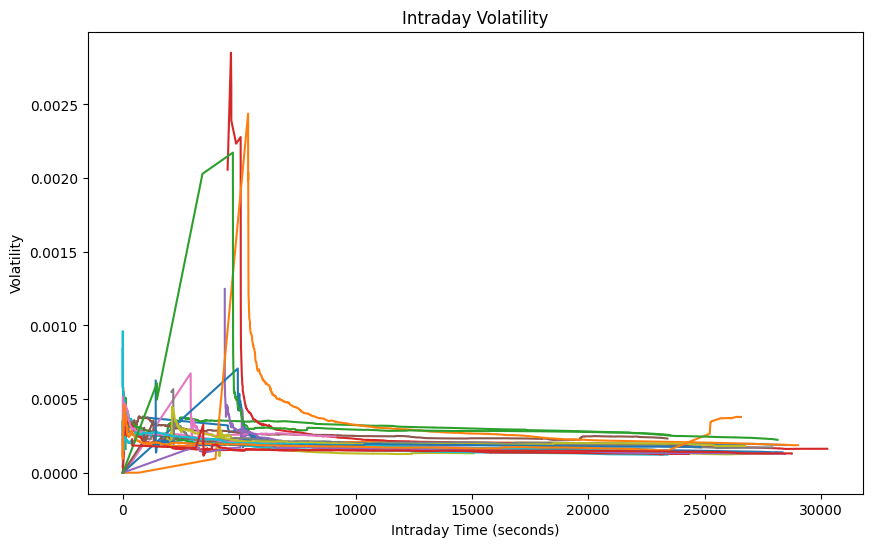

In [69]:
plot_intraday_volatility(aapl)

#### Not sure the following are necessary or make sense...? &#x2193;

In [50]:
def plot_ticks_spectrogram(df):
    """
    Plots the order size (magnitude) changes over time for each day of ticks represented in the DataFrame
    as a spectrogram. 
    """
    
    grouped_data = df.groupby(df.index.date)
    
    plt.figure(figsize=(10, 6))
    
    for day, day_data in grouped_data:
        start_time = day_data.index.min()
        day_data['time_seconds'] = (day_data.index - start_time).total_seconds()
        
        plt.specgram(day_data['size'], NFFT=256, Fs=1 / (day_data['time_seconds'].diff().mean()), cmap='viridis', label=f'Day {day}')
    
    plt.xlabel('Time (seconds from market open)')
    plt.ylabel('Frequency')
    plt.title('Ticks Spectrogram')
    plt.legend()
    plt.colorbar(label='Magnitude (Size of Order)')
    plt.show()

/var/folders/nm/zdng4t6j7msc8nd7phngmnr80000gn/T/ipykernel_9555/3121950598.py:17: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=249).
  plt.specgram(day_data['size'], NFFT=256, Fs=1 / (day_data['time_seconds'].diff().mean()), cmap='viridis', label=f'Day {day}')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


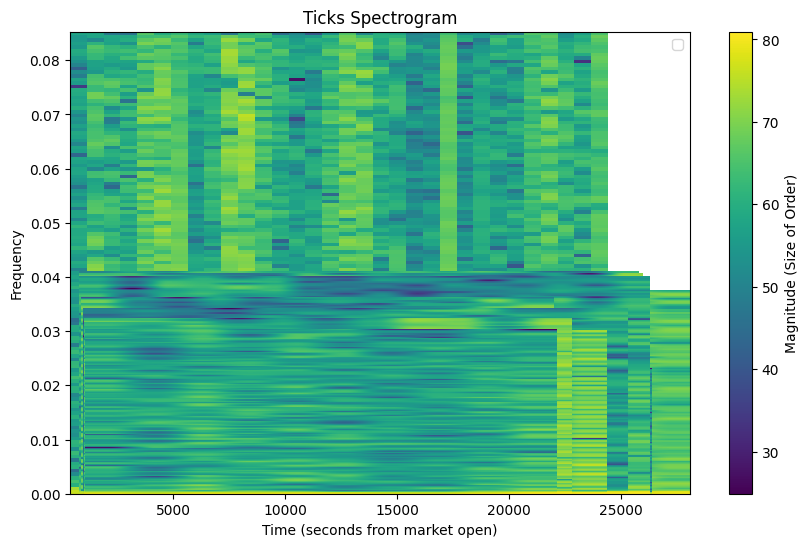

In [51]:
plot_ticks_spectrogram(qqq)

In [27]:
def plot_ticks_frequency(df):
    """Plot the number of ticks per second."""
    
    df['time_seconds'] = (df.index - df.index.min()).total_seconds()
    
    ticks_per_second = df.groupby('time_seconds').size()
    
    plt.plot(ticks_per_second.index, ticks_per_second.values, label='Ticks per Second')
    
    # Customize the plot
    plt.xlabel('Time (seconds from market open)')
    plt.ylabel('Ticks')
    custom_xticks = range(0, int(df['time_seconds'].max()) + 1, 10000)
    plt.xticks(custom_xticks)
    plt.title('Ticks Frequency Over Market Hours')
    plt.show()

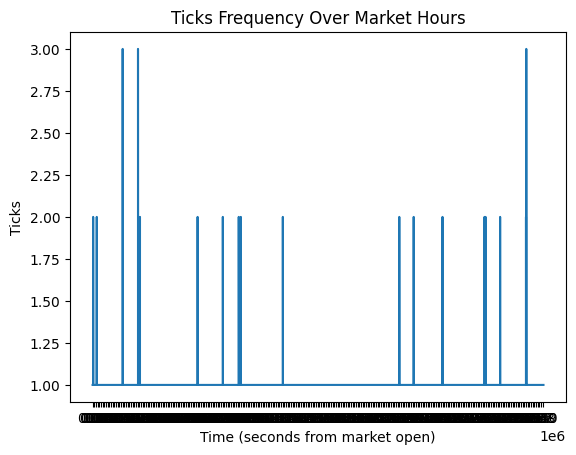

In [28]:
plot_ticks_frequency(qqq)